## Adult Census Classifier

September 2020

The goal of the demo below is to train a binary classifier on a dataset to predict a column income_bracket which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.

XGBoost is a Decision Tree type of ensemble supervised binary classifier that trains models in succession, with each new model being trained to correct the errors made by previous ones.  

More here on eXtreme Gradient Boosted Trees by Frank Kane >> https://youtu.be/OQKQHNCVf5k


In [1]:
import time
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read data
source: https://archive.ics.uci.edu/ml/datasets/census+income

In [43]:
import csv
import pandas as pd
from urllib.request import urlopen

g = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
with open('./adult.data', 'b+w') as f:
    f.write(g.read())

In [44]:
col = ['age','workclass','fnlwgt','education','edu_code','marital_status','occupation',
       'relationship','race','gender','capital_gain','capital_loss','hours_per_week',
       'country','income']

adult_df = pd.read_csv('./adult.data', names=col)
print(adult_df.shape)

(32561, 15)


## Create numerical label: income_level

In [45]:
adult_df["income"] = adult_df.income.str.strip()
cond = (adult_df.income==">50K")
adult_df["income_level"] = 0
adult_df.loc[cond, "income_level"] = 1

print(adult_df.groupby(["income_level","income"]).size()/len(adult_df))

income_level  income
0             <=50K     0.75919
1             >50K      0.24081
dtype: float64


# Data Exploration & Visualization

In [46]:
# check missing values
print(adult_df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
edu_code          0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
country           0
income            0
income_level      0
dtype: int64


In [47]:
# print data types
print(adult_df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
edu_code           int64
marital_status    object
occupation        object
relationship      object
race              object
gender            object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
country           object
income            object
income_level       int64
dtype: object


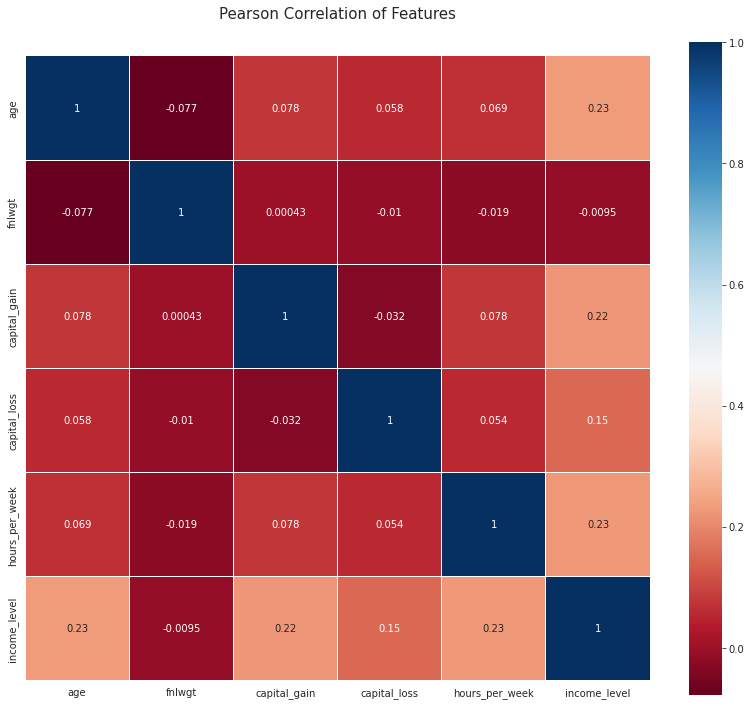

In [48]:
#num_feats = train_df.dtypes[train_df.dtypes != "object"].index
num_feats = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week', 'income_level']
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(adult_df[num_feats].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Age

In [49]:
print(adult_df.age.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["age"].mean()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64



,income_level,age
0,0,36.783738
1,1,44.249841


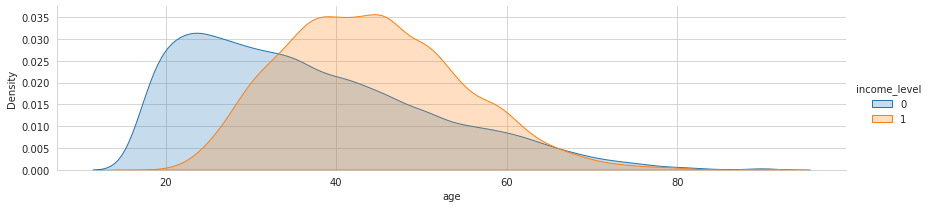

In [50]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'age', shade= True)\
   .add_legend()

## workclass: categorical

In [51]:
adult_df["workclass"] = adult_df.workclass.str.strip()
work_cnt = adult_df.workclass.value_counts()
print(work_cnt)

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

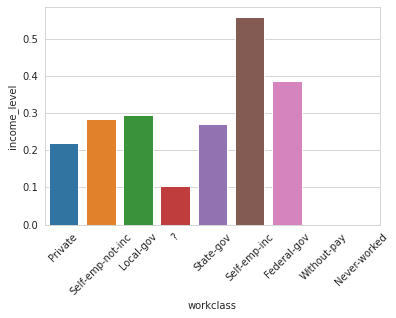

In [52]:
work_perc = adult_df.groupby(["workclass"], as_index=False)["income_level"].mean()
sns.barplot(x="workclass", y="income_level", data=work_perc, order=list(work_cnt.index))  
plt.xticks(rotation=45)

## fnlwgt

In [53]:
print(adult_df.fnlwgt.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["fnlwgt"].mean()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64



,income_level,fnlwgt
0,0,190340.86517
1,1,188005.00000


## education & edu_code: categorical

In [54]:
adult_df["education"] = adult_df.education.str.strip()
print(adult_df.groupby(["education","edu_code"]).size().sort_values(ascending=False))

education     edu_code
HS-grad       9           10501
Some-college  10           7291
Bachelors     13           5355
Masters       14           1723
Assoc-voc     11           1382
11th          7            1175
Assoc-acdm    12           1067
10th          6             933
7th-8th       4             646
Prof-school   15            576
9th           5             514
12th          8             433
Doctorate     16            413
5th-6th       3             333
1st-4th       2             168
Preschool     1              51
dtype: int64


In [ ]:
marital_perc = adult_df.groupby(["marital_status"], as_index=False)["income_level"].mean()
sns.barplot(x="marital_status", y="income_level", data=marital_perc, order=list(marital_cnt.index))  

## marital_status: categorical

In [55]:
adult_df["marital_status"] = adult_df.marital_status.str.strip()
marital_cnt = adult_df.marital_status.value_counts()
print(marital_cnt)

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

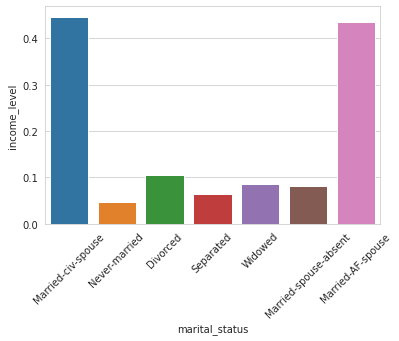

In [56]:
marital_perc = adult_df.groupby(["marital_status"], as_index=False)["income_level"].mean()
g = sns.barplot(x="marital_status", y="income_level", data=marital_perc, order=list(marital_cnt.index)) 
#g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.xticks(rotation=45)

## occupation: categorical

In [57]:
adult_df["occupation"] = adult_df.occupation.str.strip()
occu_cnt = adult_df.occupation.value_counts()
print(occu_cnt)

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


In [58]:
occu_perc = adult_df.groupby(["occupation"], as_index=False)["income_level"].mean()
print(occu_perc.sort_values("income_level", ascending=False))
#sns.barplot(x="occupation", y="income_level", data=occu_perc, order=list(occu_cnt.index))                                                                          

           occupation  income_level
4     Exec-managerial      0.484014
10     Prof-specialty      0.449034
11    Protective-serv      0.325116
13       Tech-support      0.304957
12              Sales      0.269315
3        Craft-repair      0.226641
14   Transport-moving      0.200376
1        Adm-clerical      0.134483
7   Machine-op-inspct      0.124875
5     Farming-fishing      0.115694
2        Armed-Forces      0.111111
0                   ?      0.103635
6   Handlers-cleaners      0.062774
8       Other-service      0.041578
9     Priv-house-serv      0.006711


## relationship: categorical

In [59]:
adult_df["relationship"] = adult_df.relationship.str.strip()
relation_cnt = adult_df.relationship.value_counts()
print(relation_cnt)

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


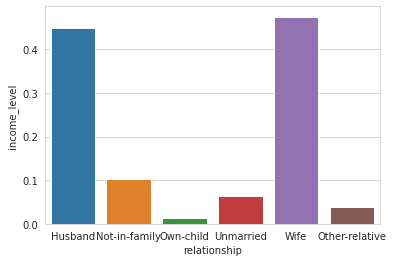

In [60]:
relation_perc = adult_df.groupby(["relationship"], as_index=False)["income_level"].mean()
sns.barplot(x="relationship", y="income_level", data=relation_perc, order=list(relation_cnt.index))                                                                          

## race: categorical

In [61]:
adult_df["race"] = adult_df.race.str.strip()
race_cnt = adult_df.race.value_counts()
print(race_cnt)

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


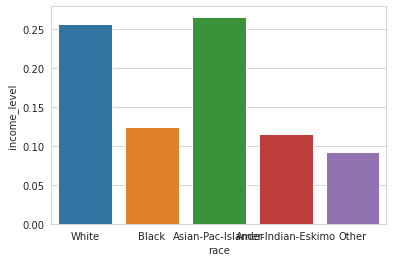

In [62]:
race_perc = adult_df.groupby(["race"], as_index=False)["income_level"].mean()
sns.barplot(x="race", y="income_level", data=race_perc, order=list(race_cnt.index))

## gender: categorical

In [63]:
adult_df["gender"] = adult_df.gender.str.strip()
print(adult_df.gender.value_counts())

Male      21790
Female    10771
Name: gender, dtype: int64


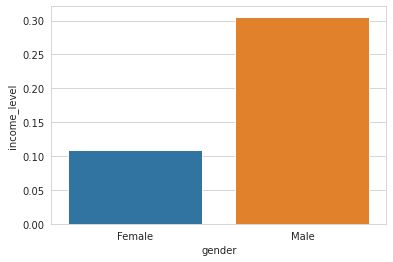

In [64]:
gender_perc = adult_df.groupby(["gender"], as_index=False)["income_level"].mean()
sns.barplot(x="gender", y="income_level", data=gender_perc)

## capital_gain: numerical

In [65]:
print(adult_df.capital_gain.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["capital_gain"].mean()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64



,income_level,capital_gain
0,0,148.752468
1,1,4006.142456


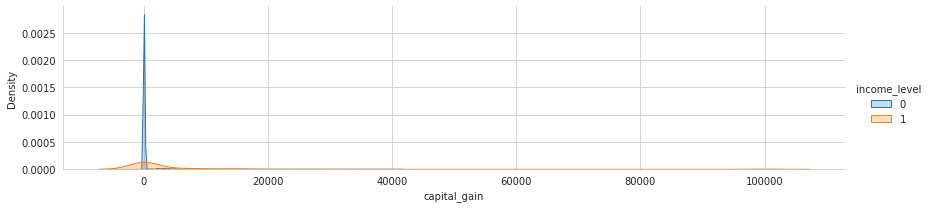

In [66]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'capital_gain', shade= True)\
   .add_legend()

## capital_loss: numerical

In [67]:
print(adult_df.capital_loss.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["capital_loss"].mean()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64



,income_level,capital_loss
0,0,53.142921
1,1,195.001530


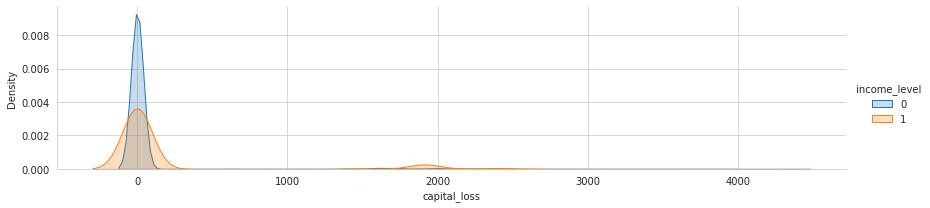

In [68]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'capital_loss', shade= True)\
   .add_legend()

## hours_per_week: numerical

In [69]:
print(adult_df.hours_per_week.describe())
print()
adult_df.groupby(["hours_per_week"], as_index=False)["income_level"].mean()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64



,hours_per_week,income_level
0,1,0.100000
1,2,0.250000
2,3,0.025641
3,4,0.055556
4,5,0.116667
5,6,0.125000
6,7,0.153846
7,8,0.075862
8,9,0.055556
9,10,0.071942


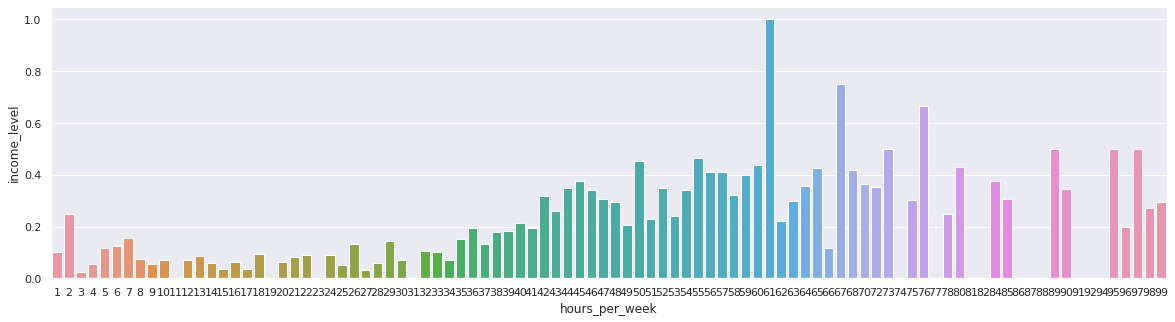

In [70]:
hour_perc = adult_df.groupby(["hours_per_week"], as_index=False)["income_level"].mean()
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(x="hours_per_week", y="income_level", data=hour_perc)

## country: categorical

In [71]:
adult_df["country"] = adult_df.country.str.strip()
print("{} coutries in the dataset".format(adult_df.country.nunique()))
print()
print("Top 10 countries in terms of record count")
print(adult_df.country.value_counts().head(10))
print()
print("US account for {:.2f}%".format(len(adult_df.loc[adult_df.country=="United-States"])/len(adult_df)))

42 coutries in the dataset

Top 10 countries in terms of record count
United-States    29170
Mexico             643
?                  583
Philippines        198
Germany            137
Canada             121
Puerto-Rico        114
El-Salvador        106
India              100
Cuba                95
Name: country, dtype: int64

US account for 0.90%


In [72]:
country_perc = adult_df.groupby(["country"], as_index=False)["income_level"].mean()
country_perc.sort_values("income_level", ascending=False).head(10)

,country,income_level
20,Iran,0.418605
10,France,0.413793
19,India,0.400000
36,Taiwan,0.392157
24,Japan,0.387097
41,Yugoslavia,0.375000
1,Cambodia,0.368421
22,Italy,0.342466
9,England,0.333333
2,Canada,0.322314


In [74]:
adult_df

,age,workclass,fnlwgt,education,edu_code,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,country,income,income_level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0


# Data Transformation: one-hot encoding

In [75]:
# don't consider education
keep_col = ['age','workclass','fnlwgt','edu_code','marital_status','occupation',
            'relationship','race','gender','capital_gain','capital_loss','hours_per_week','country']

X = pd.get_dummies(adult_df[keep_col])
y = adult_df.income_level.values
print(adult_df.shape, X.shape, y.shape)

(32561, 16) (32561, 92) (32561,)


# Machine Learning

Parameter tuning is more an art than a science - here's a good background 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

The model here suggests the following (but does not preclude further adjustments):

*   colsample_bylevel - subsample ratio of columns for each split, in each depth
*   colsample_bytree - fraction of columns randomly sampled for each tree
*   gamma - minimum loss reduction required to make splits
*   eta - learning rate
*   max_depth - max depth of tree, controls over-fitting
*   min_child_weight - min sum of observation weights, controls over-fitting
*   alpha - form of constraint on highly correlated variables (lasso)
*   lambda - form of constraint on highly correlated variables (ridge)
*   subsample - fraction of observations randomly sampled for each tree
*   objective - defines loss function, the model below uses logistic regression
*   eval_metric - metric for validation data, the model below uses negative log
*   seed - random number seed


In [76]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

In [77]:
# Train a XGBoost classifier
start_time = time.time()
print("Train model")

params = {'colsample_bylevel': 1.0,
          'colsample_bytree': 0.9,
          'gamma' : 1.0,
          'eta' : 0.05,
          'max_depth' : 16,
          'min_child_weight' : 0.5,
          'alpha': 30.0,
          'lambda': 10.0,
          'subsample': 0.9,
          'objective' : 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 2019}

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(xgb_train, 'train'), (xgb_test, 'eval')]
 
start_time = time.time()
xgb_clf = xgb.train(params, 
                    xgb_train, 
                    10000, 
                    watchlist, 
                    early_stopping_rounds=50, 
                    verbose_eval=10)

print('Execution time: {:0.2f}m'.format((time.time()-start_time)/60))
# [1024]	train-logloss:0.278169	eval-logloss:0.292103

Train model
[0]	train-logloss:0.665685	eval-logloss:0.665962
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.493069	eval-logloss:0.495313
[20]	train-logloss:0.408911	eval-logloss:0.41294
[30]	train-logloss:0.36371	eval-logloss:0.368606
[40]	train-logloss:0.336713	eval-logloss:0.342213
[50]	train-logloss:0.319953	eval-logloss:0.3262
[60]	train-logloss:0.309494	eval-logloss:0.316857
[70]	train-logloss:0.302495	eval-logloss:0.310718
[80]	train-logloss:0.297454	eval-logloss:0.306296
[90]	train-logloss:0.294034	eval-logloss:0.303283
[100]	train-logloss:0.29152	eval-logloss:0.301287
[110]	train-logloss:0.289473	eval-logloss:0.299634
[120]	train-logloss:0.288062	eval-logloss:0.298517
[130]	train-logloss:0.286848	eval-logloss:0.297673
[140]	train-logloss:0.286039	eval-logloss:0.297125
[150]	train-logloss:0.285143	eval-logloss:0.296409
[160]	train-logloss:0.284377	eval-loglo

## Performance evaluation

ROC or Receiver Operating Characteristic curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). It is a quick measure of the model's robustness, which in the following below yields 86.8% accuracy.

More here >> https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [78]:
def plot_roc(y_test, yp_test):
    fpr, tpr, thresholds = roc_curve(y_test, yp_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC, order prob by descending order
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Accuracy: 0.8681
ROC AUC: 0.9194


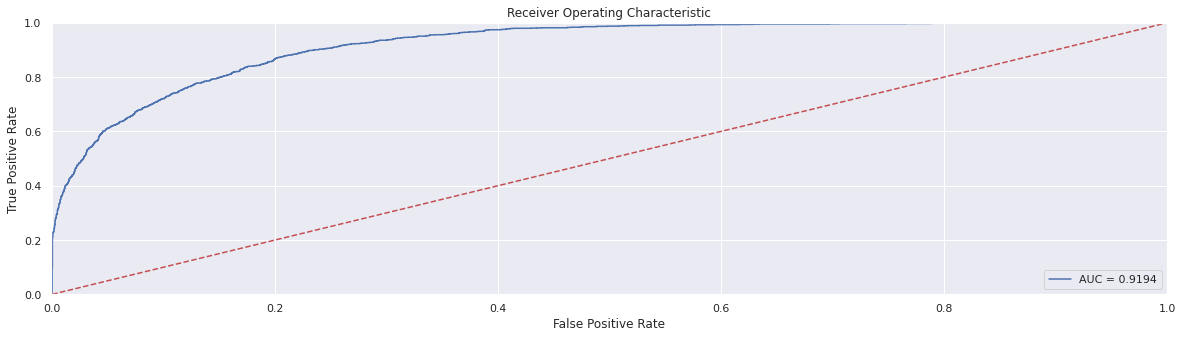

In [79]:
y_test_prob = xgb_clf.predict(xgb_test, ntree_limit=xgb_clf.best_ntree_limit)
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_prob)))
plot_roc(y_test, y_test_prob)
# Accuracy: 0.8681

In [85]:
# Examine predictions based on category 
# For example 'age' in the dataset, regardless of value, leans towards or predicts '0' or <$50K income level 
predictions = dict(zip(X_test, (round(value) for value in y_test_pred)))
predictions

{'age': 0,
 'fnlwgt': 0,
 'edu_code': 0,
 'capital_gain': 0,
 'capital_loss': 0,
 'hours_per_week': 1,
 'workclass_?': 0,
 'workclass_Federal-gov': 0,
 'workclass_Local-gov': 0,
 'workclass_Never-worked': 0,
 'workclass_Private': 0,
 'workclass_Self-emp-inc': 0,
 'workclass_Self-emp-not-inc': 0,
 'workclass_State-gov': 1,
 'workclass_Without-pay': 0,
 'marital_status_Divorced': 0,
 'marital_status_Married-AF-spouse': 0,
 'marital_status_Married-civ-spouse': 1,
 'marital_status_Married-spouse-absent': 0,
 'marital_status_Never-married': 0,
 'marital_status_Separated': 0,
 'marital_status_Widowed': 0,
 'occupation_?': 1,
 'occupation_Adm-clerical': 1,
 'occupation_Armed-Forces': 0,
 'occupation_Craft-repair': 0,
 'occupation_Exec-managerial': 0,
 'occupation_Farming-fishing': 0,
 'occupation_Handlers-cleaners': 0,
 'occupation_Machine-op-inspct': 1,
 'occupation_Other-service': 0,
 'occupation_Priv-house-serv': 1,
 'occupation_Prof-specialty': 0,
 'occupation_Protective-serv': 1,
 'occup

# Unsupervised Learning

As a way of comparison benchmarking, using KMeans modeling is less accurate.

In [80]:
X2 = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=2019)  
kmeans.fit(X2)  
print(kmeans.labels_)  
adult_df["kmeans_grp"] = kmeans.labels_

[1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1
 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1
 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0
 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0
 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 0 0 1 0 1 1 1 

In [81]:
print('Accuracy: {:.4f}'.format(accuracy_score(adult_df.income_level, adult_df.kmeans_grp)))

Accuracy: 0.2841



*Copyright &copy; 2020 Gino Baltazar All rights reserved.*